In [13]:
import numpy as np
import pandas as pd
import re
import os
import datetime
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    f1_score,
    confusion_matrix,
    accuracy_score
)

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import tensorflow as tf
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    TFAutoModelForSequenceClassification
)
from datasets import Dataset

from textblob import TextBlob

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

In [14]:
nltk.data.path.append('/kaggle/working/nltk_data')

In [15]:
class TextPreprocessor:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        
    def get_wordnet_pos(self, word):
        """Map POS tag to first character lemmatize() accepts"""
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                   "N": wordnet.NOUN,
                   "V": wordnet.VERB,
                   "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)
    
    def clean_text(self, text):
        # Basic cleaning
        text = re.sub(r'http\S+', '', text)
        text = re.sub(r'@\w+', '', text)
        text = re.sub(r'\$\w+', '', text)
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        text = text.lower().strip()
        
        # Tokenization
        tokens = word_tokenize(text)
        
        # Remove stop words and lemmatize
        tokens = [self.lemmatizer.lemmatize(token, self.get_wordnet_pos(token)) 
                 for token in tokens if token not in self.stop_words and len(token) > 2]
        
        return ' '.join(tokens)

In [16]:
def load_data(file_path):
    df = pd.read_csv(file_path)
    preprocessor = TextPreprocessor()
    df['cleaned_text'] = df['text'].apply(preprocessor.clean_text)
    return df

In [17]:
def create_balanced_features(X_train, y_train, sampling_strategy='auto'):
    smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
    smote_tomek = SMOTETomek(sampling_strategy=sampling_strategy, random_state=42)

    X_balanced, y_balanced = smote.fit_resample(X_train, y_train)
    return X_balanced, y_balanced

In [18]:
def create_enhanced_features(text_data, max_features=7000, ngram_range=(1, 3)):
    tfidf1 = TfidfVectorizer(max_features=max_features, ngram_range=(1, 1))
    tfidf2 = TfidfVectorizer(max_features=max_features, ngram_range=(2, 2))
    tfidf3 = TfidfVectorizer(max_features=max_features, ngram_range=(3, 3))

    sentiment_scores = np.array([[TextBlob(text).sentiment.polarity, 
                                 TextBlob(text).sentiment.subjectivity] 
                                for text in text_data])
    
    financial_indicators = np.array([[
        text.count('$'),
        len(re.findall(r'\d+', text)),
        len(re.findall(r'(up|down|rise|fall|gain|loss)', text.lower())),
        len(re.findall(r'(bull|bear|bullish|bearish)', text.lower()))
    ] for text in text_data])
    
    return [tfidf1, tfidf2, tfidf3], sentiment_scores, financial_indicators

In [19]:
def save_model_results(model_name, y_true, y_pred, folder_name):
    report = classification_report(y_true, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    report_df.to_csv(f"{folder_name}/{model_name}_classification_report.csv")
    
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.savefig(f"{folder_name}/{model_name}_confusion_matrix.png")
    plt.close()

In [20]:
def plot_model_comparison(results, folder_name):
    plt.figure(figsize=(10, 6))
    accuracies = [results[model]['accuracy'] for model in results]
    sns.barplot(x=list(results.keys()), y=accuracies, palette='viridis')
    plt.title("Model Accuracy Comparison")
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    for i, v in enumerate(accuracies):
        plt.text(i, v + 0.01, f'{v:.3f}', ha='center')
    plt.tight_layout()
    plt.savefig(f"{folder_name}/model_comparison.png")
    plt.close()

In [21]:
def plot_metrics(accuracy, f1):
    plt.figure(figsize=(8, 6))
    metrics = ['Accuracy', 'F1 Score']
    values = [accuracy, f1]
    
    plt.bar(metrics, values, color=['skyblue', 'lightgreen'])
    plt.ylim(0, 1)
    plt.title('Model Performance Metrics')
    
    for i, v in enumerate(values):
        plt.text(i, v + 0.01, f'{v:.3f}', ha='center')
    
    plt.show()

def plot_class_performance(y_val, y_pred):
    report = classification_report(y_val, y_pred, output_dict=True)
    
    classes = ['0', '1', '2']
    class_names = ['bearish', 'bullish', 'neutral']
    f1_scores = [report[c]['f1-score'] for c in classes]
    
    angles = np.linspace(0, 2*np.pi, len(classes), endpoint=False)
    
    f1_scores += [f1_scores[0]]
    angles = np.concatenate((angles, [angles[0]]))
    
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='polar'))
    ax.plot(angles, f1_scores)
    ax.fill(angles, f1_scores, alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(class_names)
    ax.set_ylim(0, 1)
    plt.title('Class-wise F1 Scores')
    plt.show()

def plot_training_metrics(accuracies, f1_scores):
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(accuracies) + 1)
    
    plt.plot(epochs, accuracies, 'b-', label='Accuracy')
    plt.plot(epochs, f1_scores, 'g-', label='F1 Score')
    
    plt.title('Training Metrics Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.show()

In [22]:
def train_svm_enhanced(train_file, val_file, folder_name=''):
    print("Loading and preprocessing data...")
    train_df = load_data(train_file)
    val_df = load_data(val_file)
    
    print("Creating features...")
    tfidf_vectorizers, sentiment_scores_train, financial_indicators_train = create_enhanced_features(train_df['cleaned_text'])
    
    _, sentiment_scores_val, financial_indicators_val = create_enhanced_features(val_df['cleaned_text'])
    
    X_train = np.hstack([
        tfidf_vectorizers[0].fit_transform(train_df['cleaned_text']).toarray(),
        tfidf_vectorizers[1].fit_transform(train_df['cleaned_text']).toarray(),
        tfidf_vectorizers[2].fit_transform(train_df['cleaned_text']).toarray(),
        sentiment_scores_train,
        financial_indicators_train
    ])
    
    X_val = np.hstack([
        tfidf_vectorizers[0].transform(val_df['cleaned_text']).toarray(),
        tfidf_vectorizers[1].transform(val_df['cleaned_text']).toarray(),
        tfidf_vectorizers[2].transform(val_df['cleaned_text']).toarray(),
        sentiment_scores_val,
        financial_indicators_val
    ])
    
    y_train = train_df['label']
    y_val = val_df['label']
    
    scaler = StandardScaler()
    numerical_features_train = np.hstack([sentiment_scores_train, financial_indicators_train])
    numerical_features_val = np.hstack([sentiment_scores_val, financial_indicators_val])
    
    numerical_features_train_scaled = scaler.fit_transform(numerical_features_train)
    numerical_features_val_scaled = scaler.transform(numerical_features_val)
    
    svm = LinearSVC(random_state=42, dual=False, class_weight="balanced")
    
    print("Training SVM...")
    svm.fit(X_train, y_train)
    
    y_pred = svm.predict(X_val)
    
    accuracy = accuracy_score(y_val, y_pred)
    print(f"\nValidation accuracy: {accuracy:.3f}")

    f1 = f1_score(y_val, y_pred, average='weighted')
    print(f"F1 Score: {f1:.3f}")

    plot_metrics(accuracy, f1)
    plot_class_performance(y_val, y_pred)
    
    cm = confusion_matrix(y_val, y_pred)
    
    cm_normalized = confusion_matrix(y_val, y_pred, normalize='true')
    plt.figure(figsize=(10,8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
                xticklabels=['bearish', 'bullish', 'neutral'],
                yticklabels=['bearish', 'bullish', 'neutral'])
    plt.title('Normalized Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    save_model_results('svm_enhanced', y_val, y_pred, folder_name)

    return svm, tfidf_vectorizers, accuracy

Training SVM...
Loading and preprocessing data...
Creating features...
Training SVM...

Validation accuracy: 0.824
F1 Score: 0.820


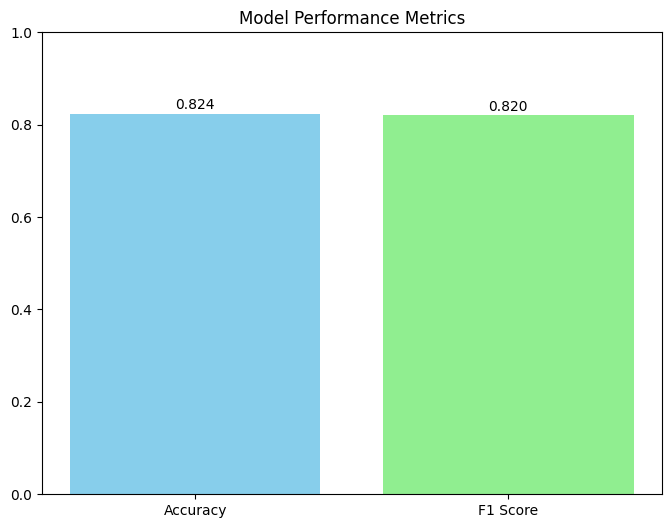

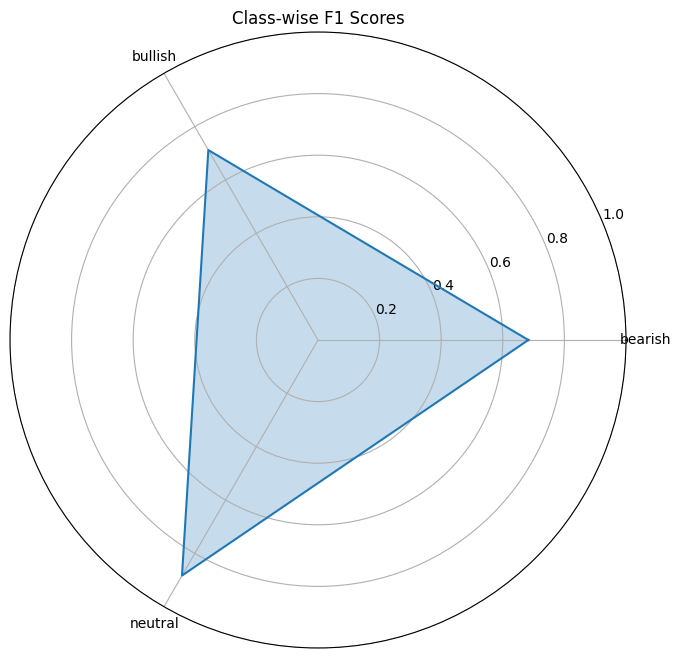

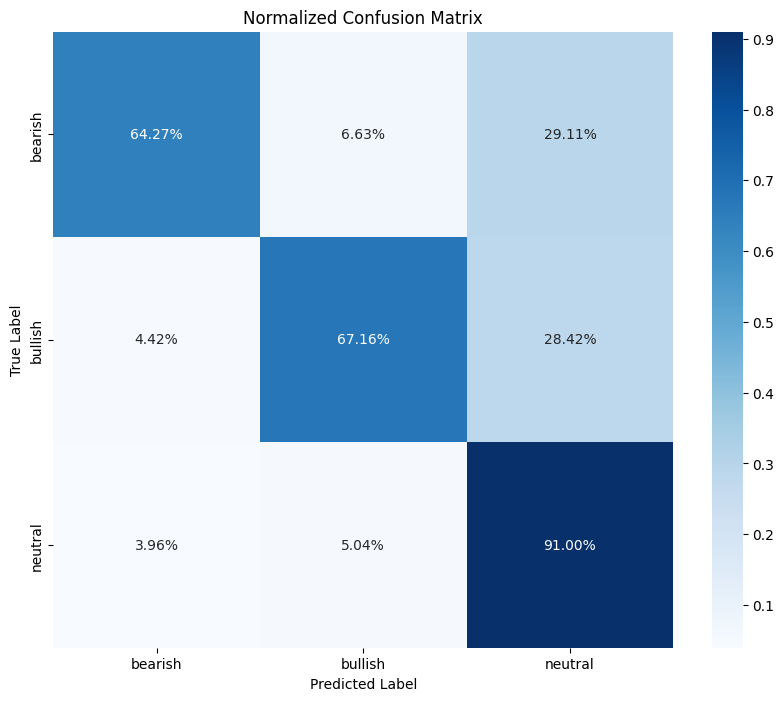

In [23]:
train_file = "/kaggle/input/twitter-financial-news-sentiment-dataset/sent_train.csv"
val_file = "/kaggle/input/twitter-financial-news-sentiment-dataset/sent_valid.csv"

print("Training SVM...")
model, vectorizers, accuracy = train_svm_enhanced(train_file, val_file)

In [24]:
with open('svm.pkl', 'wb') as f:
    pickle.dump(model, f)

with open('vectorizers.pkl', 'wb') as f:
    pickle.dump(vectorizers, f)

In [25]:
def train_transformer_model(train_file, val_file, model_name="bert-base-uncased"):
    # Load data
    train_df = load_data(train_file)
    val_df = load_data(val_file)

    # Create folder for saving outputs
    folder_name = create_run_folder()
    visualize_data(train_df, folder_name)

    # Initialize tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Tokenization function
    def tokenize_function(examples):
        return tokenizer(
            examples["cleaned_text"].tolist(),
            truncation=True,
            padding=True,
            max_length=128,
            return_tensors="tf"
        )

    # Tokenize datasets
    train_encodings = tokenize_function(train_df)
    val_encodings = tokenize_function(val_df)

    train_labels = train_df["label"].to_numpy()
    val_labels = val_df["label"].to_numpy()

    # Create TensorFlow datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((
        dict(train_encodings),
        train_labels
    )).batch(16)

    val_dataset = tf.data.Dataset.from_tensor_slices((
        dict(val_encodings),
        val_labels
    )).batch(16)

    # Load TensorFlow model
    model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    # Train the model
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=3,
        batch_size=16
    )

    # Predictions
    predictions = model.predict(val_dataset).logits
    pred_labels = np.argmax(predictions, axis=1)

    # Generate classification report
    report = classification_report(val_labels, pred_labels, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    report_df.to_csv(f"{folder_name}/classification_report.csv")

    # Confusion matrix
    cm = confusion_matrix(val_labels, pred_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=train_df['label'].unique(),
        yticklabels=train_df['label'].unique()
    )
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.savefig(f"{folder_name}/confusion_matrix.png")
    plt.close()

    return model, history